In [14]:
import torch
import torchvision
from torchvision.datasets import CIFAR100
import torchvision.transforms as tt
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import os
import numpy as np
import random
from PIL import Image
import time
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [15]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

# Предобработка данных

In [16]:
# train_transform = tt.Compose([
#                               tt.RandomHorizontalFlip(p = 0.5),
#                               tt.RandomCrop(32, padding = 4, padding_mode='reflect'),
#                               tt.ToTensor()
#                               ])


CIFAR_train  = CIFAR100(download=True, root='./data')
CIFAR_test  = CIFAR100(download = True, train = False, root= './data')

Files already downloaded and verified
Files already downloaded and verified


In [17]:
X_train = torch.FloatTensor(CIFAR_train.data)
y_train = torch.LongTensor(CIFAR_train.targets)
X_test = torch.FloatTensor(CIFAR_test.data)
y_test = torch.LongTensor(CIFAR_test.targets)

In [18]:
# compute std and mean of dataset 
# snippet https://discuss.pytorch.org/t/about-normalization-using-pre-trained-vgg16-networks/23560?u=kuzand

# loader = torch.utils.data.DataLoader(X_train, 
#                                      batch_size = 10, 
#                                      num_workers = 0, 
#                                      shuffle = False)

# mean = 0.
# std = 0.
# nb_samples = 0.

# for data in loader:
#     batch_samples = data.size(0)
#     data = data.view(batch_samples, data.size(1), -1)
#     mean += data.mean(2).sum(0)
#     std += data.std(2).sum(0)
#     nb_samples += batch_samples

# std /= nb_samples
# mean /= nb_samples

# Нормируем наши данные и реорганизуем тензор наших данных, чтобы с ним можно было работать в pytorch

In [19]:
X_train /= 255.
X_test /= 255.

tensor(19) tensor(29) tensor(0) tensor(11) tensor(1) tensor(86) tensor(90) tensor(28) tensor(23) tensor(31) tensor(39) tensor(96) tensor(82) tensor(17) tensor(71) 

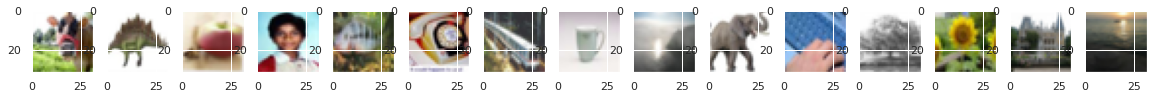

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,2))
for i in range(15):
    plt.subplot(1, 15, i+1)
    plt.imshow(X_train[i])
    print(y_train[i], end=' ')

In [21]:
X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

X_train.shape

torch.Size([50000, 3, 32, 32])

# Опишем процесс обучения

In [22]:
def train(net, X_train, y_train, X_test, y_test, batch_size = 200, num_epoch = 50,
          epoch_info_show = 10, weight_decay=0, save_net_state=False, verbose=True):
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)

    print('Check whether model on CUDA or not: ', next(net.parameters()).is_cuda) 

    loss = torch.nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3, \
                                 weight_decay=weight_decay)

    
    t = time.time()
    test_accuracy_history = []
    test_loss_history = []

    
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    for epoch in tqdm(range(1, num_epoch+1)):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()

            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = net.forward(X_batch)

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            # except RuntimeError as e:
            #     if 'CUDA out of memory' in str(e):
            #         with torch.cuda.device(device):
            #             torch.cuda.empty_cache()
            #             optimizer.zero_grad()

            optimizer.step()           
        
        net.eval()
        with torch.no_grad():
          test_preds = net.forward(X_test)
          loss_value = loss(test_preds, y_test).item()
          test_loss_history.append(loss_value)

          accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().item()
          test_accuracy_history.append(accuracy)
        
          if verbose:
            if epoch % epoch_info_show == 0:
              print('Train Epoch: {} Time: {} Accuracy: {}, GPU_Mem_alloc: {} GPU_Mem_cashed: {}'\
                  .format(epoch, time.strftime("%H:%M:%S", time.gmtime(time.time() - t)), accuracy, \
                            torch.cuda.memory_allocated(), torch.cuda.memory_reserved()))
              
    net_state = net.state_dict()
    del net
    if save_net_state:
      return test_accuracy_history, test_loss_history, net_state
    else:
      return test_accuracy_history, test_loss_history

In [23]:
# dictionaries to store loss and accuracy of the trained models
accuracies = {}
losses = {}

# Построение графиков точности и потерь

In [24]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(15, 6)})

def acc_loss_graph(accuracies, losses, net_list, save_file_name='plot.png', download=False):
    fig, (ax1, ax2) = plt.subplots(1, 2)

    for experiment_id in net_list:
        ax1.plot(accuracies[experiment_id], label=experiment_id)

    ax1.legend()
    ax1.set_title('Validation Accuracy')
    fig.tight_layout()

    for experiment_id in net_list:
        ax2.plot(losses[experiment_id], label=experiment_id)
    
    ax2.legend()
    ax2.set_title('Validation Loss');
    fig.tight_layout()

    if download:
        fig.savefig(save_file_name)

Напишем сеть CIFARNet. Более подробное описание можно получить в видео [семинара](https://stepik.org/lesson/230371/)

In [25]:
class CIFARNet(torch.nn.Module):
    def __init__(self):
        super(CIFARNet, self).__init__()

        self.conv_layers = nn.Sequential(

        nn.BatchNorm2d(3),
        nn.Conv2d(3, 16, 3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.MaxPool2d(2, 2),
        
        nn.Conv2d(16, 32, 3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2, 2),
        
        nn.Conv2d(32, 64, 3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64) 
        )

        self.linear_layers = nn.Sequential(
        nn.Linear(8 * 8 * 64, 256),
        nn.Tanh(),
        nn.BatchNorm1d(256),
        
        nn.Linear(256, 64),
        nn.Tanh(),
        nn.BatchNorm1d(64),
        
        nn.Linear(64, 100)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Создадим ResNet([оригинальная статья](https://arxiv.org/pdf/1512.03385.pdf)) для решения задачи CIFAR10 [Код](https://github.com/akamaster/pytorch_resnet_cifar10),- аналогичен за исключением инициализации весов).

In [26]:
class LambdaLayer(torch.nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(torch.nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A', 
                 use_batch_norm=True, use_drop_out=False, d_out_p=0.5):
        super(BasicBlock, self).__init__()
        self.use_batch_norm = use_batch_norm
        self.use_drop_out = use_drop_out
        self.d_out_p = d_out_p
        self.act  = torch.nn.ReLU()
        
        self.conv1 = torch.nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(planes)
        self.d_out1 = torch.nn.Dropout2d(d_out_p)
        self.conv2 = torch.nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = torch.nn.BatchNorm2d(planes)
        self.d_out2 = torch.nn.Dropout2d(d_out_p)

        self.shortcut = torch.nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """https://www.kaggle.com/mrtahion/kernel63a29c282a?scriptVersionId=17181076
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x: torch.nn.functional.pad(x[:, :, ::2, ::2], \
                                            (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     torch.nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     torch.nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = self.conv1(x)
        if self.use_batch_norm:
          out = self.bn1(out)
        if self.use_drop_out:
          out = self.d_out1(out) 
        out = self.act(out)
        out = self.conv2(out)
        
        if self.use_batch_norm:
          out = self.bn2(out)
        if self.use_drop_out:
          out = self.d_out2(out)
          
        out += self.shortcut(x)
        out = self.act(out)
        return out


class ResNet(torch.nn.Module):
    def __init__(self, block, num_blocks, num_classes=100,
                 use_batch_norm=True, use_drop_out=False, d_out_p=0.5):
        super(ResNet, self).__init__()
        self.use_batch_norm = use_batch_norm
        self.use_drop_out = use_drop_out
        self.d_out_p = d_out_p
        self.in_planes = 16
        self.act  = torch.nn.ReLU()

        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.d_out1 = torch.nn.Dropout2d(d_out_p)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = torch.nn.Linear(64, num_classes)


    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride,
                                use_batch_norm=self.use_batch_norm,
                               use_drop_out=self.use_drop_out, 
                               d_out_p=self.d_out_p))
            self.in_planes = planes * block.expansion

        return torch.nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        if self.use_batch_norm:
          out = self.bn1(out)
        if self.use_drop_out:
          out = self.d_out1(out)
          
        out = self.act(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = torch.nn.functional.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [27]:
def resnet110():
    return ResNet(BasicBlock, [18, 18, 18])
  
def resnet110_no_bn():
    return ResNet(BasicBlock, [18, 18, 18], use_batch_norm=False) 

def resnet110_d_out15():
    return ResNet(BasicBlock, [18, 18, 18], use_drop_out=True, d_out_p=0.15)
  
def resnet20():
    return ResNet(BasicBlock, [3, 3, 3])  
  
def resnet20_d_out5():
    return ResNet(BasicBlock, [3, 3, 3], use_drop_out=True)
  
def resnet20_d_out3(**kwargs):
    return ResNet(BasicBlock, [3, 3, 3], use_drop_out=True, d_out_p=0.3)
  
def resnet20_d_out8():
    return ResNet(BasicBlock, [3, 3, 3], use_drop_out=True, d_out_p=0.8)
  
def resnet20_d_out15():
    return ResNet(BasicBlock, [3, 3, 3], use_drop_out=True, d_out_p=0.15)

In [ ]:
accuracies['cifar_net'], losses['cifar_net'] = \
    train(CIFARNet(), X_train, y_train, X_test, y_test)


Check whether model on CUDA or not:  True


 20%|██        | 10/50 [00:46<03:02,  4.57s/it]

Train Epoch: 10 Time: 00:00:46 Accuracy: 0.35019999742507935, GPU_Mem_alloc: 147924480 GPU_Mem_cashed: 1675624448


 40%|████      | 20/50 [01:32<02:17,  4.57s/it]

Train Epoch: 20 Time: 00:01:32 Accuracy: 0.353300005197525, GPU_Mem_alloc: 147924480 GPU_Mem_cashed: 1675624448


 60%|██████    | 30/50 [02:17<01:31,  4.55s/it]

Train Epoch: 30 Time: 00:02:17 Accuracy: 0.36399999260902405, GPU_Mem_alloc: 147924480 GPU_Mem_cashed: 1675624448


 80%|████████  | 40/50 [03:03<00:45,  4.55s/it]

Train Epoch: 40 Time: 00:03:03 Accuracy: 0.3617999851703644, GPU_Mem_alloc: 147924480 GPU_Mem_cashed: 1675624448


100%|██████████| 50/50 [03:48<00:00,  4.57s/it]

Train Epoch: 50 Time: 00:03:48 Accuracy: 0.35510000586509705, GPU_Mem_alloc: 147924480 GPU_Mem_cashed: 1675624448


In [28]:
accuracies['resnet20'], losses['resnet20'] = \
    train(resnet20(), X_train, y_train, X_test, y_test)

Check whether model on CUDA or not:  True


 20%|██        | 10/50 [05:46<23:08, 34.72s/it]

Train Epoch: 10 Time: 00:05:46 Accuracy: 0.4380999803543091, GPU_Mem_alloc: 134848512 GPU_Mem_cashed: 3107979264


 40%|████      | 20/50 [11:33<17:19, 34.65s/it]

Train Epoch: 20 Time: 00:11:33 Accuracy: 0.4691999852657318, GPU_Mem_alloc: 134848512 GPU_Mem_cashed: 3107979264


 60%|██████    | 30/50 [17:19<11:33, 34.68s/it]

Train Epoch: 30 Time: 00:17:19 Accuracy: 0.44369998574256897, GPU_Mem_alloc: 134848512 GPU_Mem_cashed: 3107979264


 80%|████████  | 40/50 [23:05<05:45, 34.55s/it]

Train Epoch: 40 Time: 00:23:05 Accuracy: 0.4447000026702881, GPU_Mem_alloc: 134848512 GPU_Mem_cashed: 3107979264


100%|██████████| 50/50 [28:50<00:00, 34.61s/it]

Train Epoch: 50 Time: 00:28:50 Accuracy: 0.4348999857902527, GPU_Mem_alloc: 134848512 GPU_Mem_cashed: 3107979264


In [ ]:
from torchvision.models import resnet18

accuracies['resnet18'], losses['resnet18'] = \
    train(resnet18(), X_train, y_train, X_test, y_test)

Check whether model on CUDA or not:  True


 20%|██        | 10/50 [03:25<13:41, 20.55s/it]

Train Epoch: 10 Time: 00:03:25 Accuracy: 0.3863999843597412, GPU_Mem_alloc: 357132800 GPU_Mem_cashed: 3017801728


 40%|████      | 20/50 [06:50<10:16, 20.55s/it]

Train Epoch: 20 Time: 00:06:50 Accuracy: 0.40449997782707214, GPU_Mem_alloc: 357132800 GPU_Mem_cashed: 3017801728


 60%|██████    | 30/50 [10:15<06:50, 20.50s/it]

Train Epoch: 30 Time: 00:10:15 Accuracy: 0.38119998574256897, GPU_Mem_alloc: 357132800 GPU_Mem_cashed: 3017801728


 80%|████████  | 40/50 [13:40<03:25, 20.54s/it]

Train Epoch: 40 Time: 00:13:40 Accuracy: 0.3955000042915344, GPU_Mem_alloc: 357132800 GPU_Mem_cashed: 3017801728


100%|██████████| 50/50 [17:06<00:00, 20.52s/it]

Train Epoch: 50 Time: 00:17:06 Accuracy: 0.4277999997138977, GPU_Mem_alloc: 357132800 GPU_Mem_cashed: 3017801728


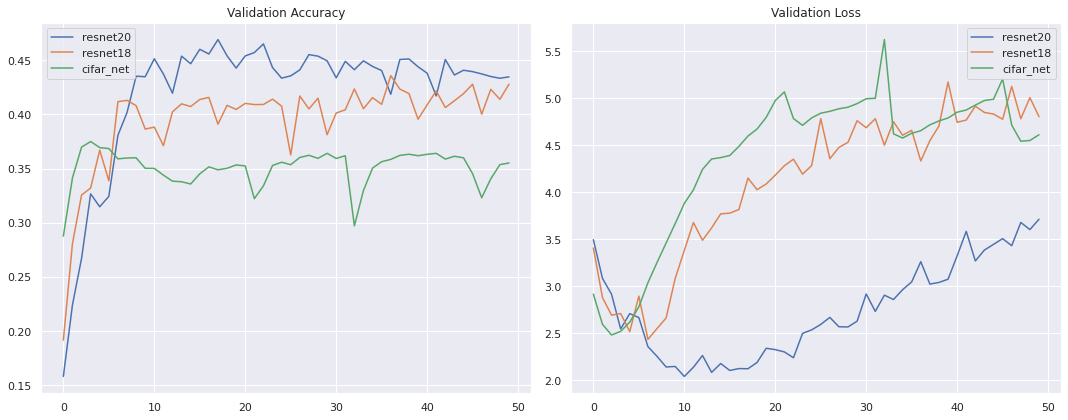

In [ ]:
acc_loss_graph(accuracies, losses, ['resnet20', 'resnet18', 'cifar_net'])

Как и следовало ожидать, Resnet18 превосходит CIFARNet, но уступает ResNet20(в том числе и во времени обучения).
На этом графике видно, что после 10-й эпохи обучать сеть уже бессмысленно, она не улучшается по качеству, но её уверенности становятся более категоричными. То есть сеть становится более уверена даже в своих неправильных предсказаниях, из-за чего график лосса сильно растёт.

# ResNet110 и batch normalization.
Теперь обучим ResNet110 в изначальном варианте и в варианте с отключеными BatchNorm слоями. Для обучения снизим размер батча до 64.

Можно ожидать, что изменения размера батча повлияет на результат работы сети. Чтобы сравнения было релевантным обучим ResNet20 используя такой же размер батча(batch_size=64).

In [ ]:
# accuracies['resnet110'], losses['resnet110'] = \
#     train(resnet110(), X_train, y_train, X_test, y_test, batch_size=64)

In [ ]:
# accuracies['resnet110_no_bn'], losses['resnet110_no_bn'] = \
#     train(resnet110_no_bn(), X_train, y_train, X_test, y_test, batch_size=64)

In [ ]:
accuracies['resnet20 bs=64'], losses['resnet20 bs=64'] = \
    train(resnet20(), X_train, y_train, X_test, y_test, batch_size=64)

Check whether model on CUDA or not:  True


 20%|██        | 10/50 [06:58<27:51, 41.78s/it]

Train Epoch: 10 Time: 00:06:58 Accuracy: 0.4642999768257141, GPU_Mem_alloc: 132512256 GPU_Mem_cashed: 3133145088


 40%|████      | 20/50 [13:55<20:53, 41.79s/it]

Train Epoch: 20 Time: 00:13:55 Accuracy: 0.5054000020027161, GPU_Mem_alloc: 132512256 GPU_Mem_cashed: 3133145088


 60%|██████    | 30/50 [20:54<13:56, 41.80s/it]

Train Epoch: 30 Time: 00:20:54 Accuracy: 0.49139997363090515, GPU_Mem_alloc: 132512256 GPU_Mem_cashed: 3133145088


 80%|████████  | 40/50 [27:52<06:58, 41.81s/it]

Train Epoch: 40 Time: 00:27:52 Accuracy: 0.4664999842643738, GPU_Mem_alloc: 132512256 GPU_Mem_cashed: 3133145088


100%|██████████| 50/50 [34:49<00:00, 41.80s/it]

Train Epoch: 50 Time: 00:34:49 Accuracy: 0.46959999203681946, GPU_Mem_alloc: 132512256 GPU_Mem_cashed: 3133145088


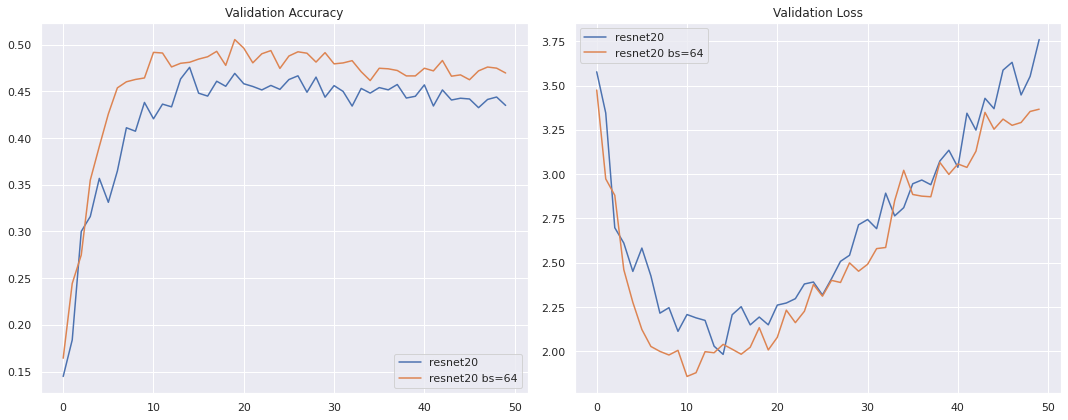

In [ ]:
acc_loss_graph(accuracies, losses, ['resnet20','resnet20 bs=64'])

При отключении BatchNorm сеть перестает эффективно обучатся.

Cтоит отметить, что уменьшение размера батча положительно повлияло на результаты ResNet20.

# DropOut
Посмотрим как будет вести себя сеть ResNet20, если после каждого слоя BatchNorm добавить слой Dropout c различными значениями параметра p.

In [ ]:
accuracies['resnet20_d_out p=0.5'], losses['resnet20_d_out p=0.5'] = \
    train(resnet20_d_out5(), X_train, y_train, X_test, y_test)

Check whether model on CUDA or not:  True


 20%|██        | 10/50 [05:55<23:42, 35.57s/it]

Train Epoch: 10 Time: 00:05:55 Accuracy: 0.09699999541044235, GPU_Mem_alloc: 134848512 GPU_Mem_cashed: 3107979264


 40%|████      | 20/50 [11:51<17:46, 35.54s/it]

Train Epoch: 20 Time: 00:11:51 Accuracy: 0.13689999282360077, GPU_Mem_alloc: 134848512 GPU_Mem_cashed: 3107979264


 60%|██████    | 30/50 [17:46<11:50, 35.52s/it]

Train Epoch: 30 Time: 00:17:46 Accuracy: 0.1673000007867813, GPU_Mem_alloc: 134848512 GPU_Mem_cashed: 3107979264


 80%|████████  | 40/50 [23:41<05:54, 35.46s/it]

Train Epoch: 40 Time: 00:23:41 Accuracy: 0.18879999220371246, GPU_Mem_alloc: 134848512 GPU_Mem_cashed: 3107979264


100%|██████████| 50/50 [29:35<00:00, 35.52s/it]

Train Epoch: 50 Time: 00:29:35 Accuracy: 0.20799998939037323, GPU_Mem_alloc: 134848512 GPU_Mem_cashed: 3107979264


In [ ]:
accuracies['resnet20_d_out p=0.3'], losses['resnet20_d_out p=0.3'] = \
    train(resnet20_d_out3(), X_train, y_train, X_test, y_test)

Check whether model on CUDA or not:  True


 20%|██        | 10/50 [05:55<23:42, 35.57s/it]

Train Epoch: 10 Time: 00:05:55 Accuracy: 0.21969999372959137, GPU_Mem_alloc: 134848512 GPU_Mem_cashed: 3107979264


 40%|████      | 20/50 [11:51<17:48, 35.63s/it]

Train Epoch: 20 Time: 00:11:51 Accuracy: 0.30959999561309814, GPU_Mem_alloc: 134848512 GPU_Mem_cashed: 3107979264


 60%|██████    | 30/50 [17:47<11:51, 35.56s/it]

Train Epoch: 30 Time: 00:17:47 Accuracy: 0.3490999937057495, GPU_Mem_alloc: 134848512 GPU_Mem_cashed: 3107979264


 80%|████████  | 40/50 [23:43<05:56, 35.60s/it]

Train Epoch: 40 Time: 00:23:43 Accuracy: 0.3798999786376953, GPU_Mem_alloc: 134848512 GPU_Mem_cashed: 3107979264


100%|██████████| 50/50 [29:38<00:00, 35.57s/it]

Train Epoch: 50 Time: 00:29:38 Accuracy: 0.3926999866962433, GPU_Mem_alloc: 134848512 GPU_Mem_cashed: 3107979264


In [ ]:
accuracies['resnet20_d_out p=0.15'], losses['resnet20_d_out p=0.15'] = \
    train(resnet20_d_out15(), X_train, y_train, X_test, y_test)

Check whether model on CUDA or not:  True


 20%|██        | 10/50 [05:57<23:50, 35.75s/it]

Train Epoch: 10 Time: 00:05:57 Accuracy: 0.3312999904155731, GPU_Mem_alloc: 268845568 GPU_Mem_cashed: 3768582144


 40%|████      | 20/50 [11:55<17:52, 35.75s/it]

Train Epoch: 20 Time: 00:11:55 Accuracy: 0.4414999783039093, GPU_Mem_alloc: 268845568 GPU_Mem_cashed: 3768582144


 60%|██████    | 30/50 [17:52<11:53, 35.69s/it]

Train Epoch: 30 Time: 00:17:52 Accuracy: 0.49049997329711914, GPU_Mem_alloc: 268845568 GPU_Mem_cashed: 3768582144


 80%|████████  | 40/50 [23:48<05:56, 35.67s/it]

Train Epoch: 40 Time: 00:23:48 Accuracy: 0.5142999887466431, GPU_Mem_alloc: 268845568 GPU_Mem_cashed: 3768582144


100%|██████████| 50/50 [29:45<00:00, 35.72s/it]

Train Epoch: 50 Time: 00:29:45 Accuracy: 0.5288999676704407, GPU_Mem_alloc: 268845568 GPU_Mem_cashed: 3768582144


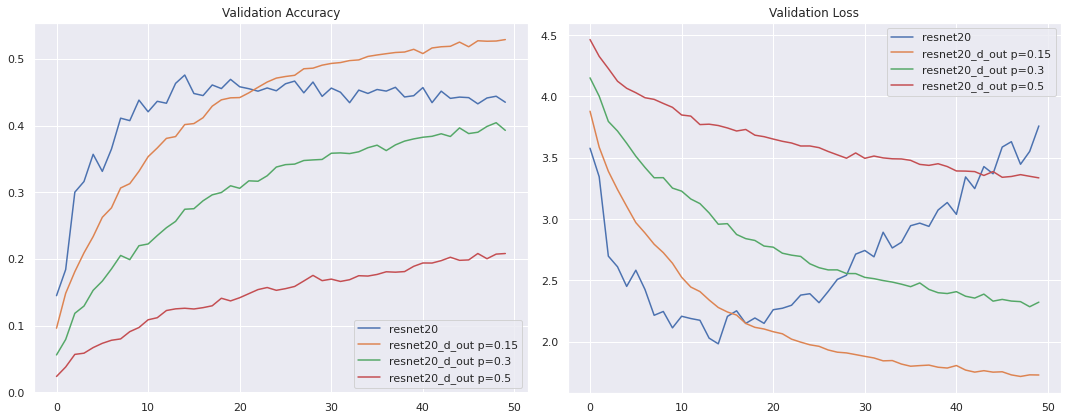

In [ ]:
acc_loss_graph(accuracies, losses, ['resnet20', 'resnet20_d_out p=0.15', 'resnet20_d_out p=0.3', 'resnet20_d_out p=0.5'])

На графиках можно увидеть, что при больших значениях параметра p сеть перестает эффективно обучатся. С уменьшением значения параметра слоев DropOut результаты приближаются к оригинальной сети. И при значении p=0.15 результат превосходит результат сети без DropOut слоев. При этом не наступает переобучения на заданном промежутке.

# L2-регуляризация
Посмотрим как повлияет на работу ResNet20 применение l2-регуляризации

In [29]:
accuracies['resnet20 wd=1e-5'], losses['resnet20 wd=1e-5'] = \
    train(resnet20(), X_train, y_train, X_test, y_test, weight_decay=1e-5)

Check whether model on CUDA or not:  True


 20%|██        | 10/50 [05:46<23:06, 34.65s/it]

Train Epoch: 10 Time: 00:05:46 Accuracy: 0.4172999858856201, GPU_Mem_alloc: 134848512 GPU_Mem_cashed: 3107979264


 40%|████      | 20/50 [11:32<17:19, 34.64s/it]

Train Epoch: 20 Time: 00:11:32 Accuracy: 0.45559999346733093, GPU_Mem_alloc: 134848512 GPU_Mem_cashed: 3107979264


 60%|██████    | 30/50 [17:19<11:32, 34.65s/it]

Train Epoch: 30 Time: 00:17:19 Accuracy: 0.4625999927520752, GPU_Mem_alloc: 134848512 GPU_Mem_cashed: 3107979264


 80%|████████  | 40/50 [23:05<05:46, 34.66s/it]

Train Epoch: 40 Time: 00:23:05 Accuracy: 0.4341999888420105, GPU_Mem_alloc: 134848512 GPU_Mem_cashed: 3107979264


100%|██████████| 50/50 [28:52<00:00, 34.65s/it]

Train Epoch: 50 Time: 00:28:52 Accuracy: 0.44419997930526733, GPU_Mem_alloc: 134848512 GPU_Mem_cashed: 3107979264


In [30]:
accuracies['resnet20 wd=1e-4'], losses['resnet20 wd=1e-4'] = \
    train(resnet20(), X_train, y_train, X_test, y_test, weight_decay=1e-4)

Check whether model on CUDA or not:  True


 20%|██        | 10/50 [05:46<23:05, 34.65s/it]

Train Epoch: 10 Time: 00:05:46 Accuracy: 0.45019999146461487, GPU_Mem_alloc: 134848512 GPU_Mem_cashed: 3107979264


 40%|████      | 20/50 [11:32<17:19, 34.64s/it]

Train Epoch: 20 Time: 00:11:32 Accuracy: 0.4315999746322632, GPU_Mem_alloc: 134848512 GPU_Mem_cashed: 3107979264


 60%|██████    | 30/50 [17:18<11:32, 34.61s/it]

Train Epoch: 30 Time: 00:17:18 Accuracy: 0.45749998092651367, GPU_Mem_alloc: 134848512 GPU_Mem_cashed: 3107979264


 80%|████████  | 40/50 [23:04<05:45, 34.59s/it]

Train Epoch: 40 Time: 00:23:04 Accuracy: 0.4391999840736389, GPU_Mem_alloc: 134848512 GPU_Mem_cashed: 3107979264


100%|██████████| 50/50 [28:50<00:00, 34.62s/it]

Train Epoch: 50 Time: 00:28:50 Accuracy: 0.43869999051094055, GPU_Mem_alloc: 134848512 GPU_Mem_cashed: 3107979264


In [31]:
accuracies['resnet20 wd=1e-3'], losses['resnet20 wd=1e-3'] = \
    train(resnet20(), X_train, y_train, X_test, y_test, weight_decay=1e-3)

Check whether model on CUDA or not:  True


 20%|██        | 10/50 [05:45<23:03, 34.58s/it]

Train Epoch: 10 Time: 00:05:45 Accuracy: 0.4213999807834625, GPU_Mem_alloc: 134848512 GPU_Mem_cashed: 3107979264


 40%|████      | 20/50 [11:31<17:17, 34.58s/it]

Train Epoch: 20 Time: 00:11:31 Accuracy: 0.46059998869895935, GPU_Mem_alloc: 134848512 GPU_Mem_cashed: 3107979264


 60%|██████    | 30/50 [17:17<11:31, 34.56s/it]

Train Epoch: 30 Time: 00:17:17 Accuracy: 0.4408999979496002, GPU_Mem_alloc: 134848512 GPU_Mem_cashed: 3107979264


 80%|████████  | 40/50 [23:02<05:45, 34.55s/it]

Train Epoch: 40 Time: 00:23:02 Accuracy: 0.4439999759197235, GPU_Mem_alloc: 134848512 GPU_Mem_cashed: 3107979264


100%|██████████| 50/50 [28:48<00:00, 34.56s/it]

Train Epoch: 50 Time: 00:28:48 Accuracy: 0.4562999904155731, GPU_Mem_alloc: 134848512 GPU_Mem_cashed: 3107979264


In [32]:
accuracies['resnet20 wd=1e-2'], losses['resnet20 wd=1e-2'] = \
    train(resnet20(), X_train, y_train, X_test, y_test, weight_decay=1e-2)

Check whether model on CUDA or not:  True


 20%|██        | 10/50 [05:45<23:01, 34.53s/it]

Train Epoch: 10 Time: 00:05:45 Accuracy: 0.29899999499320984, GPU_Mem_alloc: 134848512 GPU_Mem_cashed: 3107979264


 40%|████      | 20/50 [11:30<17:15, 34.53s/it]

Train Epoch: 20 Time: 00:11:30 Accuracy: 0.35439997911453247, GPU_Mem_alloc: 134848512 GPU_Mem_cashed: 3107979264


 60%|██████    | 30/50 [17:16<11:30, 34.54s/it]

Train Epoch: 30 Time: 00:17:16 Accuracy: 0.3489999771118164, GPU_Mem_alloc: 134848512 GPU_Mem_cashed: 3107979264


 80%|████████  | 40/50 [23:01<05:45, 34.51s/it]

Train Epoch: 40 Time: 00:23:01 Accuracy: 0.38509997725486755, GPU_Mem_alloc: 134848512 GPU_Mem_cashed: 3107979264


100%|██████████| 50/50 [28:46<00:00, 34.53s/it]

Train Epoch: 50 Time: 00:28:46 Accuracy: 0.39800000190734863, GPU_Mem_alloc: 134848512 GPU_Mem_cashed: 3107979264


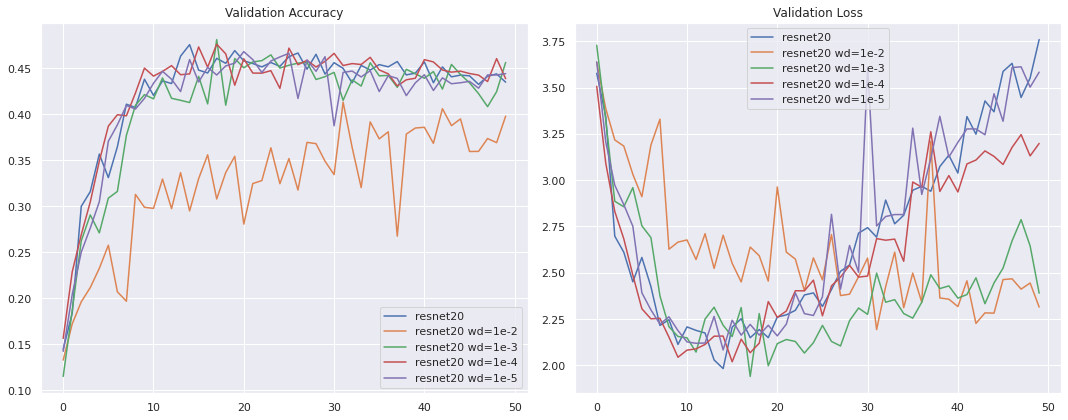

In [33]:
acc_loss_graph(accuracies, losses, ['resnet20', 'resnet20 wd=1e-2', 'resnet20 wd=1e-3','resnet20 wd=1e-4', 
                                    'resnet20 wd=1e-5'])

Применение l2-регуляризации не принесло положительных изменений. При больших значениях коэффициента регуляризации сеть, ожидаемо, демонстрирует худший результат.

Мы протестировали несколько различных архитектур ResNet и их модификаций, заметно превзлошли результаты CIFARNet.

Результаты возможно можно улучшить путём:

1) Дальнейшей модификации архитектуры,

2) Использования более продвинутых архитектур нейронных сетей,

3) Применения аугментации,

4) Создания ансамбля из несколький сетей.